# PM5 – Task F: Sonar Visualization (golden config)
- Golden damping $\alpha = 1.0$, grid 60×30 over 100 m × 100 m.
- Input for visualization: 20 Hz sinusoid scaled by $10^6$ (long wavelength, well resolved).
- Uses the existing `visualize_sonar_setup` and `create_wave_animation` helpers.


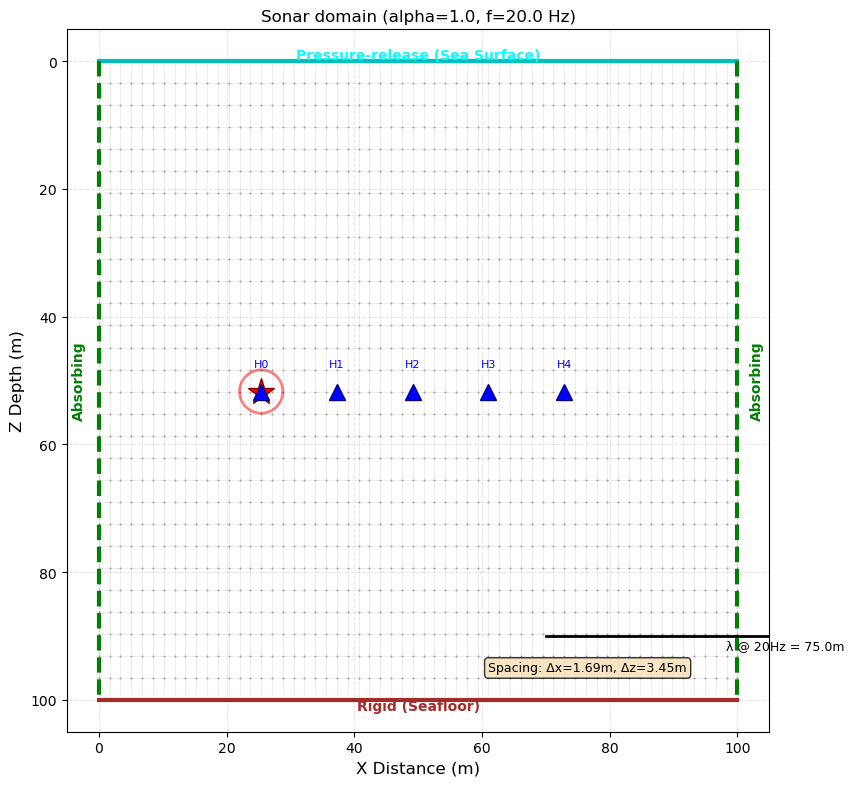

Creating animation with 750 frames (skip=2)...
Animation saved as PM5_20Hz_wave.gif


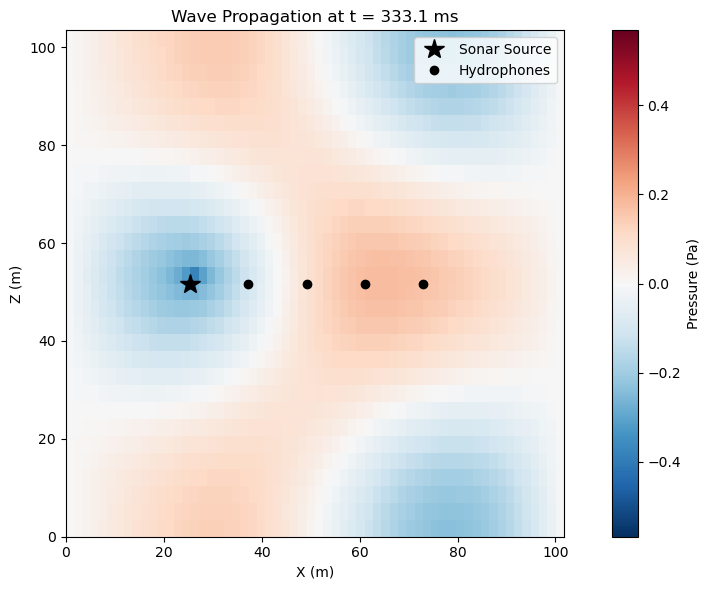

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.sparse as sp
from scipy.integrate import solve_ivp
from getParam_Sonar import getParam_Sonar
from visualize_sonar import visualize_sonar_setup
from create_wave_animation import create_wave_animation
# Golden configuration
alpha_golden = 1.0
golden_cfg = {"Nx": 60, "Nz": 30, "Lx": 100.0, "Lz": 100.0, "absorb_strength": 5.0}
p, x0, t0, t_stop, dt_max = getParam_Sonar(
    golden_cfg['Nx'], golden_cfg['Nz'], golden_cfg['Lx'], golden_cfg['Lz'],
    UseSparseMatrices=True, absorb_strength=golden_cfg['absorb_strength']
)
# Override damping block
A = p['A'].tolil()
N = p['Nx'] * p['Nz']
A[N:, N:] = -alpha_golden * sp.eye(N)
A = A.tocsr()
B_vec = np.ravel(p['B'].toarray())
# 20 Hz sinusoid drive
drive_scale = 1e6
f_drive = 20.0
u_fn = lambda t: drive_scale * np.sin(2 * np.pi * f_drive * t)
# Time grid: reuse t_stop, 300 samples
t_eval = np.linspace(t0, t_stop * 5, 300 * 5)
def simulate_linear(A, B_vec, x0, u_fn, t_eval, max_step, rtol=1e-7, atol=1e-10):
    def rhs(t, x):
        return A.dot(x) + B_vec * u_fn(t)
    sol = solve_ivp(rhs, (t_eval[0], t_eval[-1]), x0.reshape(-1),
                    t_eval=t_eval, method='RK45', max_step=max_step,
                    rtol=rtol, atol=atol)
    return sol.t, sol.y
t_vis, X_vis = simulate_linear(A, B_vec, x0, u_fn, t_eval, dt_max)
# Static visualization of domain
fig, ax = visualize_sonar_setup(p, show_grid=True, show_boundary_labels=True)
ax.set_title(f"Sonar domain (alpha={alpha_golden}, f={f_drive} Hz)")
plt.show()
# Wave animation of pressure field
anim = create_wave_animation(X_vis, t_vis, p, save_filename='PM5_20Hz_wave.gif', frame_skip=2, max_frames=0, fps=20)


## Notes
- Wavelength at 20 Hz is long relative to the grid; the domain plot includes a 20 Hz wavelength scale bar.
- Hydrophone positions and source location are annotated; boundaries show absorbing vs surface/seafloor conditions.
- The animation uses the pressure field from the RK45 simulation with the 20 Hz drive and saves to `PM5_20Hz_wave.gif`.
